In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
import pytorch_lightning as pl
import torch
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import skimage.measure as measure
import scipy
from skimage.morphology import disk
import torchvision

import torch.nn as nn

import ufl
import dolfin as dlf
import dolfin_adjoint as d_ad
import pyadjoint as pyad

from torchvision import transforms

import warnings
import time
warnings.filterwarnings('ignore')
from tqdm.autonotebook import tqdm  


from utils.nn import ConvNextCell, DownsampleLayer
from utils.PB_utils import Dataset, PB_Unet
import utils.proc as proc


%load_ext autoreload
%autoreload 2
%matplotlib inline

pl.seed_everything(1)
np.random.seed(1)

Global seed set to 1
Global seed set to 1


In [8]:
data_root="/project/vitelli/cell_stress/MeshDatasets/imrescale-4_maxcellvol-20/"

#['08_cell_1', '08_cell_2', '08_cell_4', '10_cell_1', '10_cell_2', '10_cell_3',
# '10_cell_4', '11_cell_0', '11_cell_1', '11_cell_4', '17_cell_0', '17_cell_2',
# '17_cell_3', '17_cell_4', 'myo_cell_0', 'myo_cell_4', 'myo_cell_5',
# 'myo_cell_8', 'myo_cell_9', 'pax_cell_2', 'pax_cell_4']


#cells_to_include = ['08_cell_1', '08_cell_2', '08_cell_4', '10_cell_1', '10_cell_2', '10_cell_3',
#                    '10_cell_4', '11_cell_0', '17_cell_0', '17_cell_2',
#                    '17_cell_3', 'myo_cell_0', 'myo_cell_4', 'myo_cell_5',
#                    'myo_cell_8', 'myo_cell_9', 'pax_cell_2', 'pax_cell_4']

cells_to_include = ['11_cell_1', '11_cell_0','myo_cell_5','myo_cell_2','myo_cell_3','08_cell_4','pax_cell_2']
#cells_to_include = ['myo_cell_8']


dataset = Dataset(root=data_root, 
                  cells_to_include=cells_to_include, 
                  frames_to_include = np.arange(0,120,3),#[0,39,79,119], # np.arange(2) 
                  n_include=160, indices=160)
print(len(dataset.red_dataset))
print(len(dataset))

144
144


In [9]:
dataset.df.head(100)
#print(dataset.df.cell.unique())

,index,cell,frame,mesh_file,npy_file,mesh_len
0,0,08_cell_4,15,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1877
1,1,08_cell_4,45,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1189
2,2,08_cell_4,57,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,2085
3,3,08_cell_4,60,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,2005
4,4,08_cell_4,63,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1767
...,...,...,...,...,...,...
95,106,myo_cell_2,45,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1567
96,107,myo_cell_2,48,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1438
97,109,myo_cell_2,54,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1615
98,110,myo_cell_2,6,/project/vitelli/cell_stress/MeshDatasets/imre...,/project/vitelli/cell_stress/MeshDatasets/imre...,1743


# Model

    1. Zyx -> Y (im) -> Y (mesh vals). Need to make im_to_mesh_val fct in pytorch
    2. Y mesh vals used for fenics. only use compute_gradient from J.
    3. Update step

In [10]:
loss_all = []

gpu_train = True
pbar_LRs = tqdm(total=1, desc='')
for LR in [1e-5]:
    for N_layers in [10]:
        pbar_LRs.set_description(f'LR {LR:0.2e} N_layers {N_layers}')
        torch.manual_seed(0)
        np.random.seed(0)

        model = PB_Unet( 
                         kernel_size=15,
                         LR=LR,
                         N_layers=N_layers,
                         N_latent_layers=N_layers,
                         hidden_channels=32,
                         gamma=0.995,
                         regularization=None,
                         batch_size=16, #len(dataset.red_dataset),
                         exp=False)
        
        if gpu_train: model.to(torch.device('cuda:0'))

        sig_init = 1e-1
        a_init = 1e-1
        d_ad.set_working_tape(d_ad.Tape())
        #d_ad.get_working_tape().get_blocks()[:] = []
        print(len(d_ad.get_working_tape().get_blocks()))

        pretrain_loss = []
        t0 = time.time()
        epochs = 301
        pbar_outer = tqdm(total=epochs, desc='')
        pbar_inner = tqdm(total=len(dataset), desc='')
        for i in range(epochs):
            pbar_outer.update(1) # update progress bar for each iteration step
            pbar_inner.reset()
            for s in range(len(dataset)):
                pbar_inner.set_description(f'Sample {s}')
                pbar_inner.update(1) # update progress bar for each iteration step
                m = i*len(dataset) + s

                sample = dataset[s]
                
                if gpu_train: sample['zyx'] = sample['zyx'].to(torch.device('cuda:0'))
                if gpu_train: sample['Y_init'] = sample['Y_init'].to(torch.device('cuda:0'))
                if gpu_train: sample['mask_bool'] = sample['mask_bool'].to(torch.device('cuda:0'))


                pretrain_loss.append( [x.detach().cpu().numpy() for x in model.pretrain(sample['zyx'], 1e2*sample['Y_init'], 
                                                                                  sig_init, a_init, mask=sample['mask_bool'])][0])
                if np.any(np.isnan(pretrain_loss)):
                    raise ValueError(f"Nans encountered, iter {m}\t{pretrain_loss[-1]}")
            pbar_outer.set_description(f'Epoch {i}, loss {pretrain_loss[-1]:0.2e}')

        loss_all.append({'N_layers': N_layers, 'LR': LR, 'loss': pretrain_loss})
        pbar_LRs.update(1)


  0%|          | 0/1 [00:00<?, ?it/s]

0


  0%|          | 0/301 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
len(model.opt.param_groups)

3

In [17]:
print(model.opt)
print(model.opt.param_groups[0]['lr'])

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-05
    lr: 9.950000000000001e-06
    name: const_net
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-05
    lr: 9.950000000000001e-06
    name: convNext
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 1e-05
    lr: 9.950000000000001e-06
    name: latent
    weight_decay: 0
)
9.950000000000001e-06


In [14]:
torch.save(model.state_dict(), './allcells2_model_state_dict.pt')


tensor(2.0659e-39, device='cuda:0')
tensor(0.0076, device='cuda:0')


NameError: name 'cb_pre' is not defined

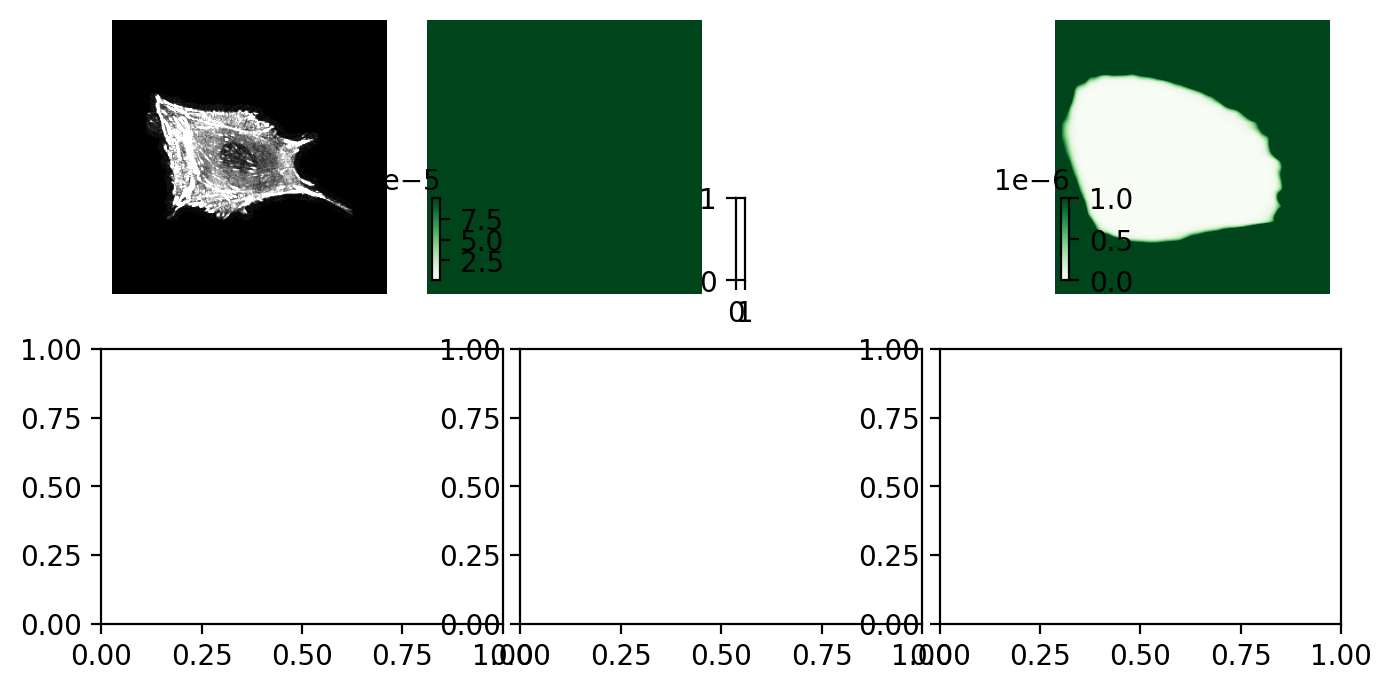

In [20]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,4),dpi=200)

gs = GridSpec(2, 12, figure=fig)
ax = {}
ax['zyx'] = fig.add_subplot(gs[0, 0:3])
ax['yinit'] = fig.add_subplot(gs[0, 3:6])

ax['ypre'] = fig.add_subplot(gs[0, 6:9])
ax['yfinal'] = fig.add_subplot(gs[0, 9:])
ax['pre_loss'] = fig.add_subplot(gs[1, 0:4])
ax['pde_loss'] = fig.add_subplot(gs[1, 4:8])
ax['consts'] = fig.add_subplot(gs[1, 8:])

for key in ['zyx','yinit','ypre','yfinal']:
    ax[key].axis('off')

sample = dataset[100]
with torch.no_grad():
    y_im, _, _ = model.forward(sample['zyx'],None)

ax['zyx'].imshow(sample['zyx'].squeeze().detach().cpu().numpy(), cmap='gray', origin='lower', vmin=0, vmax=1)

vmax = 1e-6#1e-3#1e-4#None #Y_init_scale
vmin= None
im_init = ax['yinit'].imshow(sample['Y_init'].squeeze().detach().cpu().numpy(), cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)
#im_pre = ax['ypre'].imshow(y_ims[0].squeeze().detach().numpy(), cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)
#y_post_plot = y_ims[-1].squeeze().detach().numpy()
y_post_plot = y_im.squeeze().detach().cpu().numpy()
print(y_im.min())
print(y_im.max())
#y_post_plot[sample['mask_bool'].squeeze().detach().numpy()==0] = 0
im_post = ax['yfinal'].imshow(y_post_plot, cmap='Greens', origin='lower', vmin=vmin, vmax=vmax)#, vmin=0., vmax=0.00115)

cax_init = ax['yinit'].inset_axes([0.02, 0.05, 0.03, 0.3])
cax_pre = ax['ypre'].inset_axes([0.02, 0.05, 0.03, 0.3])
cax_final = ax['yfinal'].inset_axes([0.02, 0.05, 0.03, 0.3])


cb_init = fig.colorbar(im_init, cax_init)
#cb_pre = fig.colorbar(im_pre, cax_pre)
cb_final = fig.colorbar(im_post, cax_final)

#cb_init.ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), useOffset=True)
for cb in [cb_init, cb_pre, cb_final]:
    cb.formatter.set_powerlimits((0, 0))
    cb.ax.yaxis.set_offset_position('left')
    cb.ax.yaxis.offsetText.set_fontsize(8)
    #cb.ax.yaxis.offsetText.set_text('$10^{-3}$')
    #useMathText
    

ax['pre_loss'].semilogy(np.asarray(pretrain_loss)[:,0])
ax['pde_loss'].semilogy(loss)
ax['consts'].plot(constant_evol[:,0], label='$\\sigma_a$', color='b')
ax2 = ax['consts'].twinx()
ax['consts'].plot([],[], label='$\\alpha$', color='gray')
ax2.plot(constant_evol[:,1], label='$\\alpha$', color='gray')

ax['consts'].legend(frameon=False, loc='lower right')
ax['consts'].tick_params(colors='blue', which='both', axis='y')  # 'both' refers to minor and major axes
ax2.tick_params(colors='gray', which='both', axis='y')  # 'both' refers to minor and major axes



for key in ['pre_loss','pde_loss','consts']:
    ax[key].tick_params(axis='both', which='both', direction='in')

#ax['pde_loss'].set_yticklabels([])
#ax['pde_loss'].set_ylim(None, 1e4)
ax['zyx'].set_title('Zyxin')
ax['yinit'].set_title('$Y_{init}$ ($\\propto |F|$)')
ax['ypre'].set_title('$Y$ after \npretraining')
ax['yfinal'].set_title('$Y$ after\nPDE training')
ax['pde_loss'].set_title('PDE training loss')
ax['consts'].set_title('Constants')

fig.set_facecolor('w')

# Model

In [2]:
model = PB_Unet( 
             kernel_size=15,
             LR=1e-3,
             N_layers=10,
             N_latent_layers=10,
             hidden_channels=32,
             gamma=0.995,
             regularization=None,
             batch_size=111,
             exp=False)


In [6]:
model.load_state_dict(torch.load('./cell_1_model_state_dict.pt'))

In [7]:
data_root="/project/vitelli/cell_stress/MeshDatasets/imrescale-4_maxcellvol-20/"

np.random.seed(0)
torch.manual_seed(0)


cell_1_dataset = Dataset(root=data_root, 
                  use_F_NN_or_Exp='exp', 
                  cells_to_include=['11_cell_1'], 
                  frames_to_include = np.arange(0,120),#[0,39,79,119], # np.arange(2) 
                  n_include=120, indices=120)

# Plot

In [8]:
def tricolor(f, mesh):
    import matplotlib.tri as tri 
    xy = mesh.coordinates()

    f = dlf.project(f, mesh=mesh)

    pltmesh = f.function_space().mesh()

    f = f._cpp_object
    C = f.compute_vertex_values(pltmesh)#.get_local()
    
    triang = tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())
    
    return triang, C

def triquiver(f, mesh):    
    f = dlf.project(f, mesh=mesh)

    w0 = f.compute_vertex_values(mesh)
    nv = mesh.num_vertices()
    X = mesh.coordinates()
    X = [X[:, i] for i in range(2)]
    U = [w0[i * nv: (i + 1) * nv] for i in range(2)]
    
    return X,U


In [10]:
frames = cell_1_dataset.df.frame.values
print(frames)
print(np.sort(frames))

[0 1 10 100 101 102 103 104 106 107 108 109 11 110 111 112 113 114 115 116
 117 118 119 12 13 14 15 16 17 18 19 2 20 21 22 23 25 26 27 29 3 30 31 32
 33 34 35 36 37 38 39 4 40 41 42 43 44 45 46 47 48 49 5 50 51 52 53 54 55
 56 57 58 59 6 60 61 62 63 64 65 66 67 68 69 7 70 71 72 73 74 75 76 77 78
 79 8 81 83 85 86 87 88 89 9 90 92 98 99]
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 26 27 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 81 83 85 86 87 88 89 90 92 98 99 100 101 102 103 104 106 107 108
 109 110 111 112 113 114 115 116 117 118 119]


# Make images for video

In [12]:

t0 = time.time()
if input("make video?")=='yes':
    #for frame in cell_1_dataset.df.frame.values:
    for i in range(len(cell_1_dataset)):
        sample = cell_1_dataset[i]
        frame = sample['frame']

        mesh = sample['Y_FctSpace'].mesh()

        y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

        sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
        alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

        #### Generate Y, F fields on mesh ####
        Y_mesh = d_ad.Function(sample['Y_FctSpace'])
        F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

        #y_mesh_vals[y_mesh_vals<0] = 0

        Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()

        u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh)   


        ## Plot ##


        fig,ax=plt.subplots(2,3,figsize=(9,6),dpi=200)

        mask = sample['mask_bool'].squeeze()
        #mesh = sample['Y_FctSpace'].mesh()

        for a in ax.T[1:].flat:
            a.imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)

        ax[1][0].imshow(np.zeros_like(mask), cmap='Greens', origin='lower', alpha=0.8)

        vmax = 3
        for a in ax.T[1:].T:
            im_ex = a[0].tripcolor(*tricolor(ufl.sqrt(ufl.dot(F_mesh,F_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')
            im_pr = a[1].tripcolor(*tricolor(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')

        for a in ax.flat: a.axis('off')

        arrow_width = 0.005
        dns = 2
        thresh=0.3
        X,U=triquiver( F_mesh, mesh)
        X = np.asarray([x[::dns] for x in X]).T
        U = np.asarray([x[::dns] for x in U]).T

        X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
        U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
        ax[1][1].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


        arrow_width = 0.003
        dns = 2
        X,U=triquiver( Y_mesh*u, mesh)
        X = np.asarray([x[::dns] for x in X]).T
        U = np.asarray([x[::dns] for x in U]).T

        X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
        U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
        ax[1][2].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


        ax[0][0].set_title('Zyxin')
        ax[1][0].set_title('$Y(x)$')
        ax[0][1].set_title('Target $|\\vec{F}|$')
        ax[0][2].set_title('Predicted $|\\vec{F}|$')
        ax[1][1].set_title('Target $\\vec{F}$')
        ax[1][2].set_title('Predicted $\\vec{F}$')

        ax[0][0].imshow(sample['zyx'].squeeze()/sample['zyx'].max(), cmap='gray', origin='lower', vmin=0, vmax=0.1)
        imy = ax[1][0].tripcolor(*tricolor(ufl.sqrt(ufl.dot(Y_mesh,Y_mesh)), mesh), vmin=0,vmax=2e-3, cmap='Greens')


        ### Colorbars

        imy_cax = ax[1][0].inset_axes([0.05,0.05,0.03,0.15])
        cb_y = fig.colorbar(imy, cax=imy_cax)


        imF_cax = ax[1][1].inset_axes([0.05,0.05,0.03,0.15])
        cb_F = fig.colorbar(im_ex, cax=imF_cax, ticks=[0,3])

        cb_F.ax.yaxis.set_tick_params(color='w')
        cb_F.outline.set_edgecolor('w')
        plt.setp(plt.getp(imF_cax, 'yticklabels'), color='w')
        #plt.setp(plt.getp(imF_cax, 'yticklabels'), text=[0,0])
        imF_cax.set_yticklabels([0, '3 kPa'])

        #cbar.ax.set_ylabel('F')
        plt.setp(plt.getp(imF_cax, 'ylabel'), text='F')
        plt.setp(plt.getp(imF_cax, 'ylabel'), color='w')

        for a in ax.flat:
            a.set_xlim(50,190)
            a.set_ylim(50,190)

        fig.savefig(f'./cell_1_prediction_pngs/frame_{frame}.png', format='png', bbox_inches='tight', facecolor='w')
        plt.close('all')

        print(f'Done w/ frame {frame}. Time:\t{time.time()-t0:0.2f}')

make video? n


In [13]:
F_pred = []
F_exp = []
frames = []
sigmas=[]
alphas=[]

model.eval()

for i in range(len(cell_1_dataset)):
    sample = cell_1_dataset[i]
    mesh = sample['Y_FctSpace'].mesh()
    frame = sample['frame']

    y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

    sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

    #y_mesh_vals[y_mesh_vals<0] = 0

    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()

    u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh)   

    F_pred.append( dlf.assemble(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh))*ufl.dx) )
    F_exp.append( dlf.assemble(ufl.sqrt(ufl.dot(F_mesh, F_mesh))*ufl.dx) )
    frames.append(frame)
    sigmas.append(const[0].detach().numpy())
    alphas.append(const[1].detach().numpy())

F_pred = np.asarray(F_pred)
F_exp = np.asarray(F_exp)
frames = np.asarray(frames)
sigmas= np.asarray(sigmas)
alphas=np.asarray(alphas)


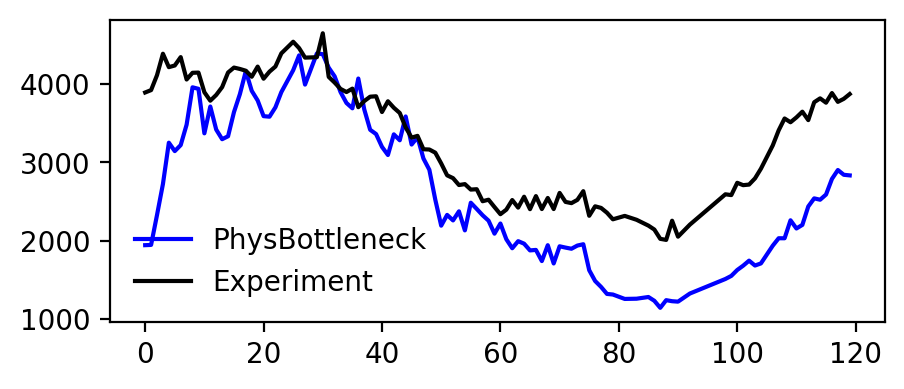

In [20]:
fig,ax=plt.subplots(1,1,figsize=(5,2),dpi=200)

idxsrt = np.argsort(frames)

ax.plot(frames[idxsrt], F_pred[idxsrt], color='b', label='PhysBottleneck')
ax.plot(frames[idxsrt], F_exp[idxsrt], color='k', label='Experiment')

ax.legend(frameon=False)


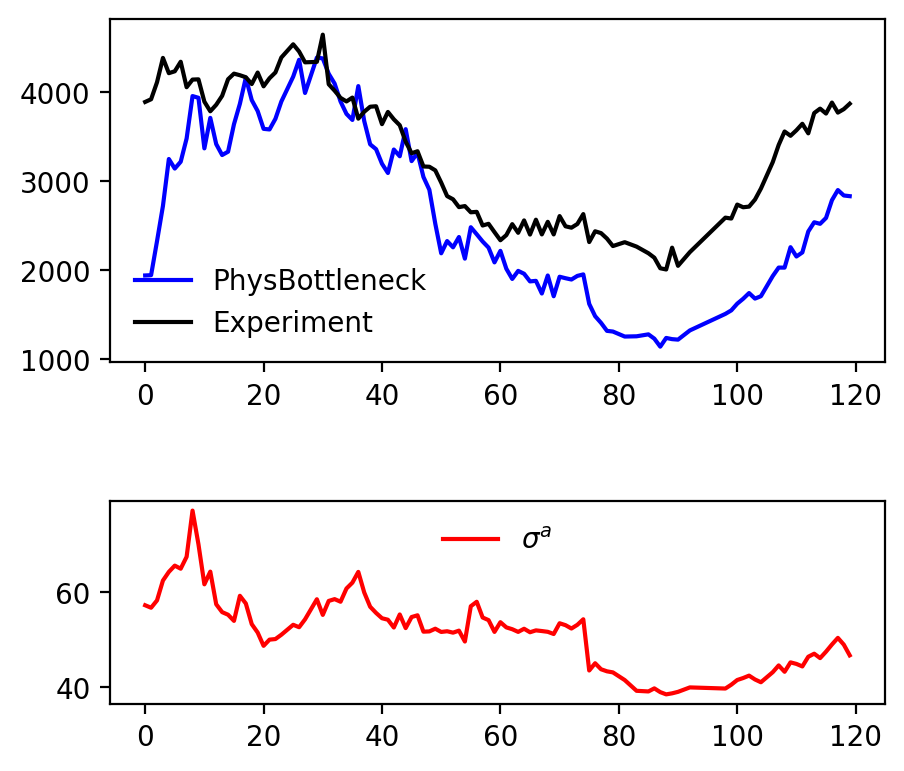

In [29]:
fig,ax=plt.subplots(2,1,figsize=(5,5),dpi=200)

idxsrt = np.argsort(frames)

ax[0].plot(frames[idxsrt], F_pred[idxsrt], color='b', label='PhysBottleneck')
ax[0].plot(frames[idxsrt], F_exp[idxsrt], color='k', label='Experiment')
ax[0].legend(frameon=False)


ax[1].plot(frames[idxsrt], sigmas[idxsrt], color='r', label='$\\sigma^a$')
#ax2=ax[1].twinx()
#ax2.plot(frames[idxsrt], alphas[idxsrt], color='gray')
#ax[1].plot([],[], color='gray', label='$\\alpha$')
ax[1].legend(frameon=False, loc='upper center')

ax[1].set_aspect(0.8)
#ax2.set_ylim(0,0.5)

In [11]:
frame_idx_map = []
for i in range(len(cell_1_dataset)):
    frame_idx_map.append([cell_1_dataset[i]['frame'], i])
    
frame_idx_map = np.asarray(frame_idx_map)

[ 3 95 37]


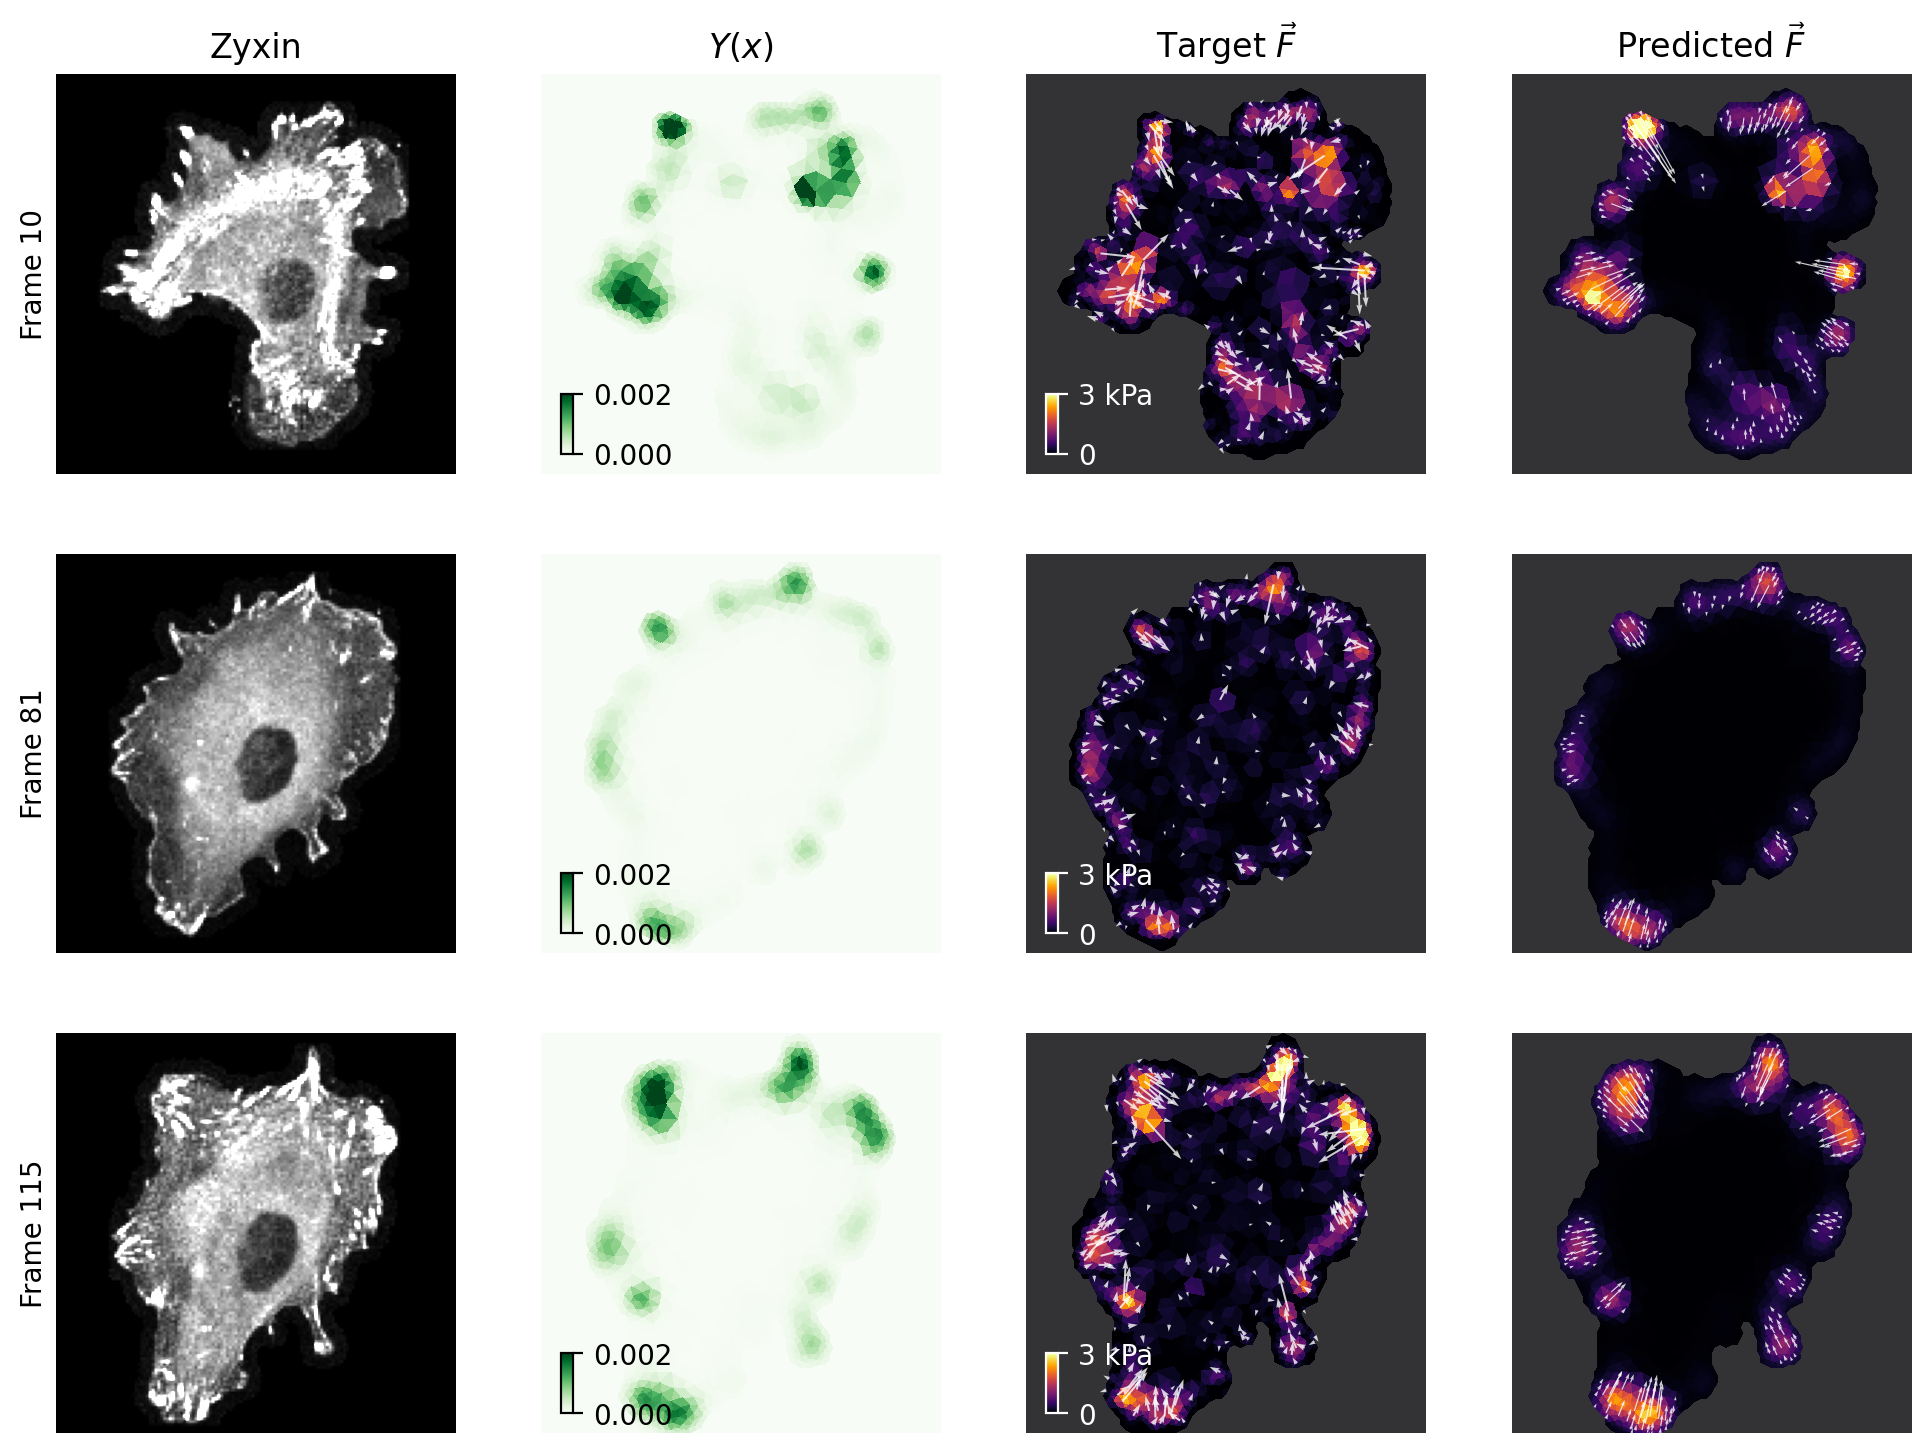

In [13]:
frames_to_plot = [10, 81, 115]

indices_to_plot = np.asarray([frame_idx_map[ frame_idx_map[:,0]==f, 1] for f in frames_to_plot]).squeeze()

print(indices_to_plot)

fig,ax=plt.subplots(len(indices_to_plot), 4, figsize=(12,9),dpi=200)

t0 = time.time()
#for frame in cell_1_dataset.df.frame.values:
for idx, a in zip(indices_to_plot, ax):
    sample = cell_1_dataset[idx]
    frame = sample['frame']

    mesh = sample['Y_FctSpace'].mesh()

    y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

    sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

    #y_mesh_vals[y_mesh_vals<0] = 0

    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()

    u,_,_ = sample['pde_forward'](Y_mesh, sigma_a, alpha, mesh) 
    
    a[0].imshow(sample['zyx'].squeeze()/sample['zyx'].max(), cmap='gray', origin='lower', vmin=0, vmax=0.1)

    ## Plot ##
    mask = sample['mask_bool'].squeeze()
    
    a[1].imshow(np.zeros_like(mask), cmap='Greens', origin='lower', alpha=0.8)
    a[2].imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)
    a[3].imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)

    vmax = 3
    im_ex = a[2].tripcolor(*tricolor(ufl.sqrt(ufl.dot(F_mesh,F_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')
    im_pr = a[3].tripcolor(*tricolor(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')


    arrow_width = 0.005
    dns = 2
    thresh=0.3
    X,U=triquiver( F_mesh, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    a[2].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    arrow_width = 0.003
    dns = 2
    X,U=triquiver( Y_mesh*u, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    a[3].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    imy = a[1].tripcolor(*tricolor(ufl.sqrt(ufl.dot(Y_mesh,Y_mesh)), mesh), vmin=0,vmax=2e-3, cmap='Greens')

    ### Colorbars
    imy_cax = a[1].inset_axes([0.05,0.05,0.03,0.15])
    cb_y = fig.colorbar(imy, cax=imy_cax)

    imF_cax = a[2].inset_axes([0.05,0.05,0.03,0.15])
    cb_F = fig.colorbar(im_ex, cax=imF_cax, ticks=[0,3])

    cb_F.ax.yaxis.set_tick_params(color='w')
    cb_F.outline.set_edgecolor('w')
    plt.setp(plt.getp(imF_cax, 'yticklabels'), color='w')
    #plt.setp(plt.getp(imF_cax, 'yticklabels'), text=[0,0])
    imF_cax.set_yticklabels([0, '3 kPa'])

    #cbar.ax.set_ylabel('F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), text='F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), color='w')
    
    a[0].text(-0.02, 0.5, f'Frame {frame}', ha='right', va='center', transform=a[0].transAxes, rotation=90)


ax[0][0].set_title('Zyxin')
ax[0][1].set_title('$Y(x)$')
ax[0][2].set_title('Target $\\vec{F}$')
ax[0][3].set_title('Predicted $\\vec{F}$')

for a in ax.flat:
    a.set_xlim(50,190)
    a.set_ylim(50,190)

for a in ax.flat: a.axis('off')

# Fake

[ 3 95 37]


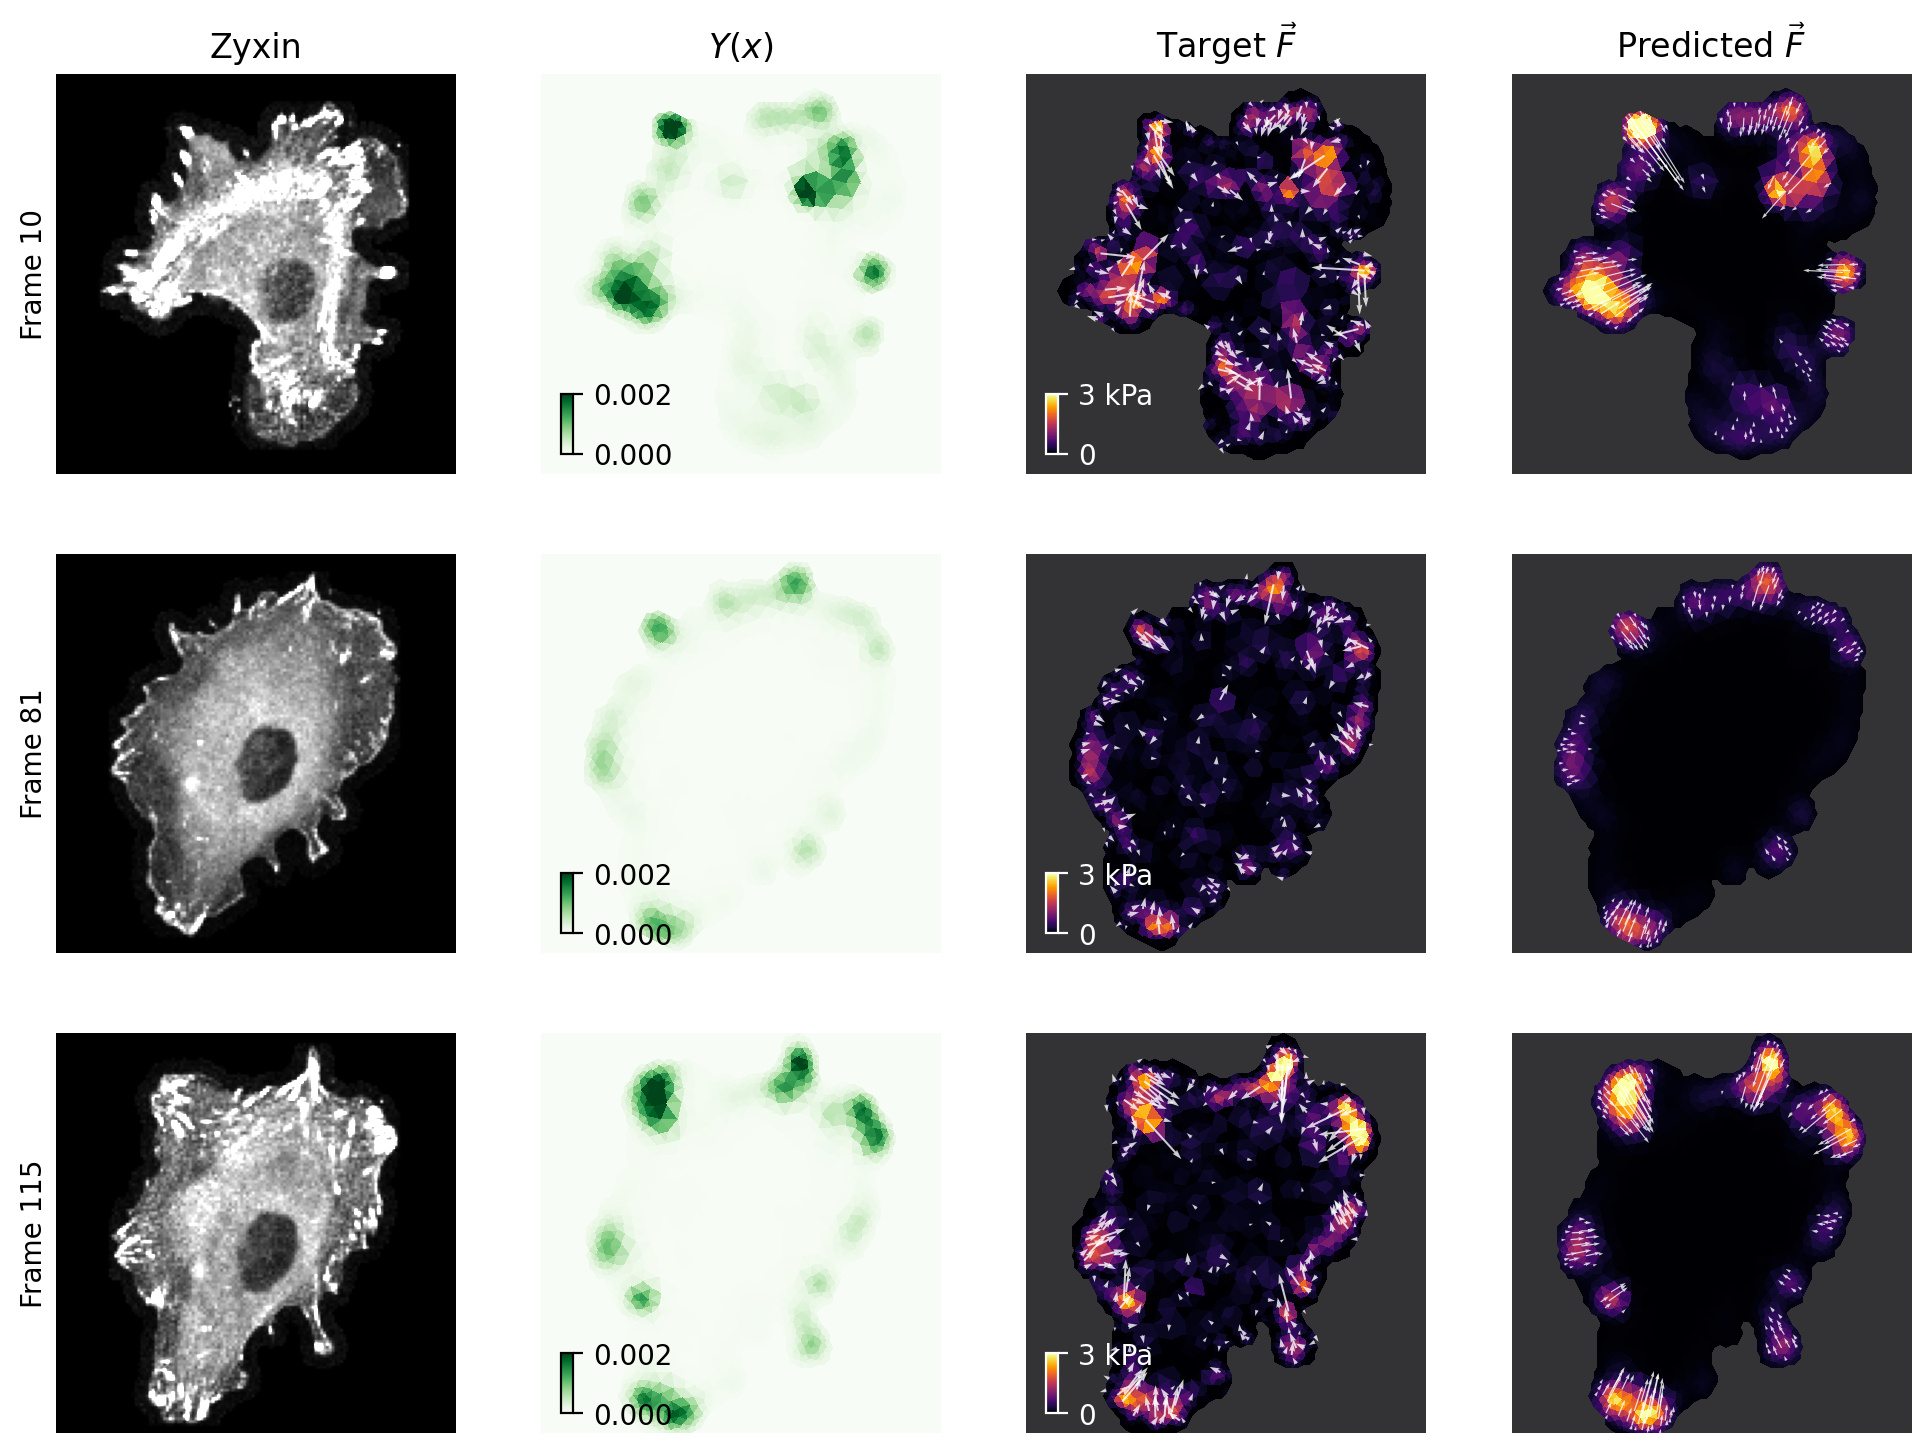

In [12]:
frames_to_plot = [10, 81, 115]

indices_to_plot = np.asarray([frame_idx_map[ frame_idx_map[:,0]==f, 1] for f in frames_to_plot]).squeeze()

print(indices_to_plot)

fig,ax=plt.subplots(len(indices_to_plot), 4, figsize=(12,9),dpi=200)

t0 = time.time()
#for frame in cell_1_dataset.df.frame.values:
for idx, a in zip(indices_to_plot, ax):
    sample = cell_1_dataset[idx]
    frame = sample['frame']

    mesh = sample['Y_FctSpace'].mesh()

    y_im, y_mesh_vals, const = model.forward(sample['zyx'], sample['Y_FctSpace'])

    sigma_a = d_ad.Constant(const[0].detach().numpy(), name = "sigma")
    alpha = d_ad.Constant(const[1].detach().numpy(), name = "alpha")

    #### Generate Y, F fields on mesh ####
    Y_mesh = d_ad.Function(sample['Y_FctSpace'])
    Y_const = d_ad.Function(sample['Y_FctSpace'])
    F_mesh = proc.vector_img_to_mesh(sample['F'].squeeze().detach().numpy(), dlf.VectorFunctionSpace(mesh, 'CG', 1, dim=2))

    #y_mesh_vals[y_mesh_vals<0] = 0

    Y_mesh.vector()[:] = y_mesh_vals.detach().numpy()
    Y_const.vector()[:] = np.mean(y_mesh_vals.detach().numpy())

    u,_,_ = sample['pde_forward'](Y_const, sigma_a, alpha, mesh) 
    
    a[0].imshow(sample['zyx'].squeeze()/sample['zyx'].max(), cmap='gray', origin='lower', vmin=0, vmax=0.1)

    ## Plot ##
    mask = sample['mask_bool'].squeeze()
    
    a[1].imshow(np.zeros_like(mask), cmap='Greens', origin='lower', alpha=0.8)
    a[2].imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)
    a[3].imshow(np.zeros_like(mask), cmap='inferno', origin='lower', alpha=0.8)

    vmax = 3
    im_ex = a[2].tripcolor(*tricolor(ufl.sqrt(ufl.dot(F_mesh,F_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')
    im_pr = a[3].tripcolor(*tricolor(ufl.sqrt(ufl.dot(u*Y_mesh,u*Y_mesh)), mesh), vmin=0,vmax=vmax, cmap='inferno')


    arrow_width = 0.005
    dns = 2
    thresh=0.3
    X,U=triquiver( F_mesh, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    a[2].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    arrow_width = 0.003
    dns = 2
    X,U=triquiver( Y_mesh*u, mesh)
    X = np.asarray([x[::dns] for x in X]).T
    U = np.asarray([x[::dns] for x in U]).T

    X = np.asarray([x for u,x in zip(U,X) if np.linalg.norm(u, axis=0)>thresh]).T
    U = np.asarray([u for u in U if np.linalg.norm(u, axis=0)>thresh]).T
    a[3].quiver(*X, *U, color='w', width=arrow_width, scale=10*vmax, alpha=0.8)


    imy = a[1].tripcolor(*tricolor(ufl.sqrt(ufl.dot(Y_mesh,Y_mesh)), mesh), vmin=0,vmax=2e-3, cmap='Greens')

    ### Colorbars

    imy_cax = a[1].inset_axes([0.05,0.05,0.03,0.15])
    cb_y = fig.colorbar(imy, cax=imy_cax)

    imF_cax = a[2].inset_axes([0.05,0.05,0.03,0.15])
    cb_F = fig.colorbar(im_ex, cax=imF_cax, ticks=[0,3])

    cb_F.ax.yaxis.set_tick_params(color='w')
    cb_F.outline.set_edgecolor('w')
    plt.setp(plt.getp(imF_cax, 'yticklabels'), color='w')
    #plt.setp(plt.getp(imF_cax, 'yticklabels'), text=[0,0])
    imF_cax.set_yticklabels([0, '3 kPa'])

    #cbar.ax.set_ylabel('F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), text='F')
    plt.setp(plt.getp(imF_cax, 'ylabel'), color='w')
    
    a[0].text(-0.02, 0.5, f'Frame {frame}', ha='right', va='center', transform=a[0].transAxes, rotation=90)


ax[0][0].set_title('Zyxin')
ax[0][1].set_title('$Y(x)$')
ax[0][2].set_title('Target $\\vec{F}$')
ax[0][3].set_title('Predicted $\\vec{F}$')

for a in ax.flat:
    a.set_xlim(50,190)
    a.set_ylim(50,190)

for a in ax.flat: a.axis('off')

In [2]:
print(10*(0.17)**2)

0.28900000000000003


In [3]:
print(20*0.17)

3.4000000000000004


# Angle errors

# Length scales

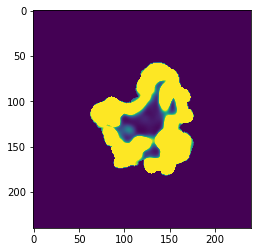

In [11]:

sample = cell_1_dataset[0]
frame = sample['frame']
mesh = sample['Y_FctSpace'].mesh()
y_im, _, const = model.forward(sample['zyx'], sample['Y_FctSpace'])
mask = sample['mask_bool'].squeeze()

plt.imshow(y_im.detach().cpu().numpy().squeeze()*(mask.detach().cpu().numpy()!=0), vmax=3e-5, vmin=0)

In [20]:
y_np = y_im.detach().cpu().numpy().squeeze()
a = const[1].detach().numpy()

L = (1./np.sqrt(y_np/a))*(4*0.17)

In [34]:
Ls = []
for i in range(100):
    sample = cell_1_dataset[i]
    frame = sample['frame']
    mesh = sample['Y_FctSpace'].mesh()
    y_im, _, const = model.forward(sample['zyx'], sample['Y_FctSpace'])
    mask = sample['mask_bool'].squeeze()
    a = const[1].detach().numpy()

    Ls.append((1./np.sqrt(y_im.squeeze()[mask!=0].mean().detach().cpu().numpy()/a))*(4*0.17))
    #print(L_avg)

Text(0, 0.5, 'Count')

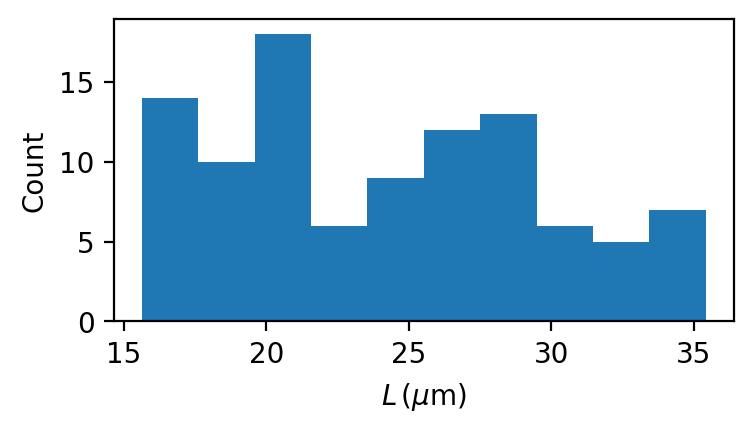

In [40]:
fig,ax=plt.subplots(1,1,figsize=(4,2),dpi=200)

ax.hist(Ls, bins=10)
ax.set_xlabel('$L \\,(\\mu$m)')
ax.set_ylabel('Count')

In [13]:
print(const[1].detach().numpy())

0.22541538


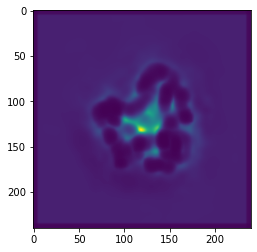

In [22]:
plt.imshow(L)

In [23]:
maskmask = mask.detach().cpu().numpy()!=0

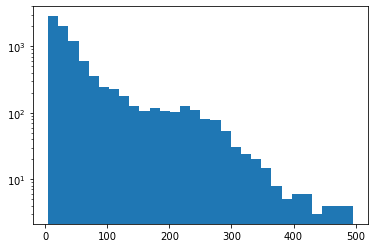

In [24]:
plt.hist(L[maskmask], log=True, bins=30);

# Attention Figures

In [169]:
#fig,ax=plt.subplots(1, 2, figsize=(12,6),dpi=200)

for i in np.random.choice(np.arange(len(cell_1_dataset)), 30, replace=False):
    sample = cell_1_dataset[i]
    frame = sample['frame']

    nnz = np.asarray(np.nonzero(sample['mask_bool'].detach().cpu().numpy().squeeze())).T
    np.random.shuffle(nnz)
    pts = nnz[:70]

    mesh = sample['Y_FctSpace'].mesh()

    model.opt.zero_grad()
    model.train()
    sample['zyx'].requires_grad = True

    y_im, y_mesh_vals, _ = model.forward(sample['zyx'], sample['Y_FctSpace'])

    #loc[:, 170, 95] = 1. # delta function

    G_all = []
    t0 = time.time()
    for pt in pts:
        loc = torch.zeros_like(y_im)

        loc[:, pt[0], pt[1]] = 1.

        G_all.append( torch.autograd.grad(y_im, sample['zyx'], grad_outputs=loc, retain_graph=True)[0].detach().cpu().numpy().squeeze())

    print(f"Time for one cell{time.time()-t0:0.2f}")

    center = np.asarray([G_all[0].shape[0]/2, G_all[0].shape[1]/2]).astype(int)
    shifts = np.asarray(center-pts)

    G_all_shifted = np.asarray([np.roll(g, shift, axis=(0,1)) for shift, g in zip(shifts, G_all)])
    
    np.save(f"./G_shifted_frame_{i}.npy", G_all_shifted)

# POS: 95, 170 (170, 95)

Time for one cell46.34
Time for one cell46.38
Time for one cell46.17
Time for one cell46.30
Time for one cell46.37
Time for one cell46.25
Time for one cell46.24
Time for one cell46.06
Time for one cell46.16
Time for one cell46.34
Time for one cell46.50
Time for one cell46.28
Time for one cell45.84
Time for one cell46.57
Time for one cell46.42
Time for one cell46.36
Time for one cell46.41
Time for one cell46.33
Time for one cell46.48
Time for one cell46.34
Time for one cell46.52
Time for one cell46.41
Time for one cell46.33
Time for one cell45.82
Time for one cell46.53
Time for one cell46.47
Time for one cell46.45
Time for one cell46.46
Time for one cell46.35
Time for one cell46.13


In [9]:
G_avgs = np.asarray([np.load(f) for f in os.listdir('./') if 'G_shifted_frame_' in f])
print(G_avgs.shape)

(30, 70, 240, 240)


In [149]:
center = np.asarray([G_all[0].shape[0]/2, G_all[0].shape[1]/2]).astype(int)
shifts = np.asarray(center-pts)

G_all_shifted = np.asarray([np.roll(g, shift, axis=(0,1)) for shift, g in zip(shifts, G_all)])
#print(G_all_shifted)

In [10]:

G_avg = np.mean(G_avgs, axis=(0,1))
print(G_avg.shape)

(240, 240)


In [150]:
G_shift = np.mean(G_all_shifted, axis=0)
G = np.mean(G_all, axis=0)

In [11]:
G_shift = G_avg

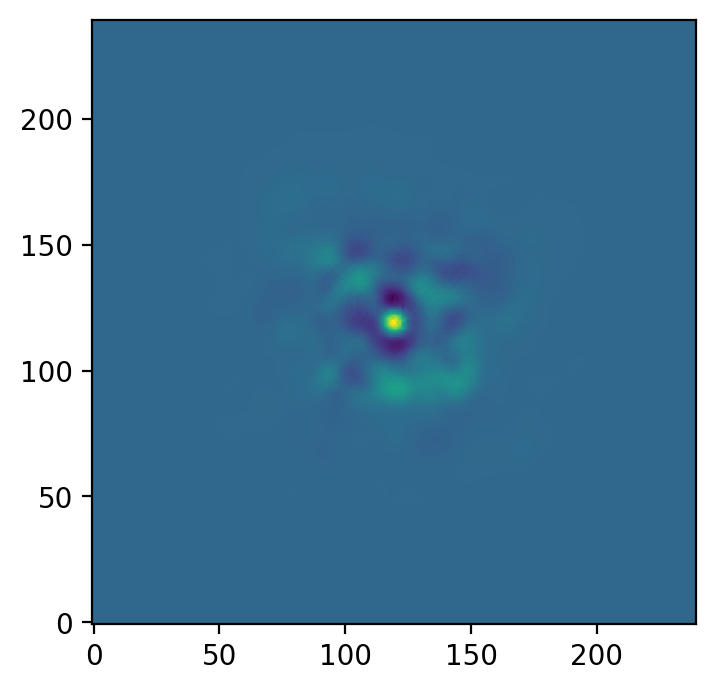

In [13]:
fig,ax=plt.subplots(1,1,figsize=(4,4),dpi=200)

#ax.imshow(G, origin='lower')
ax.imshow(G_shift, origin='lower')

#ax.axhline(G_shift.shape[0]//2, color='w')

#ax.set_ylim(138,205)
#ax.set_xlim(60,130)

(0.0, 200.0)

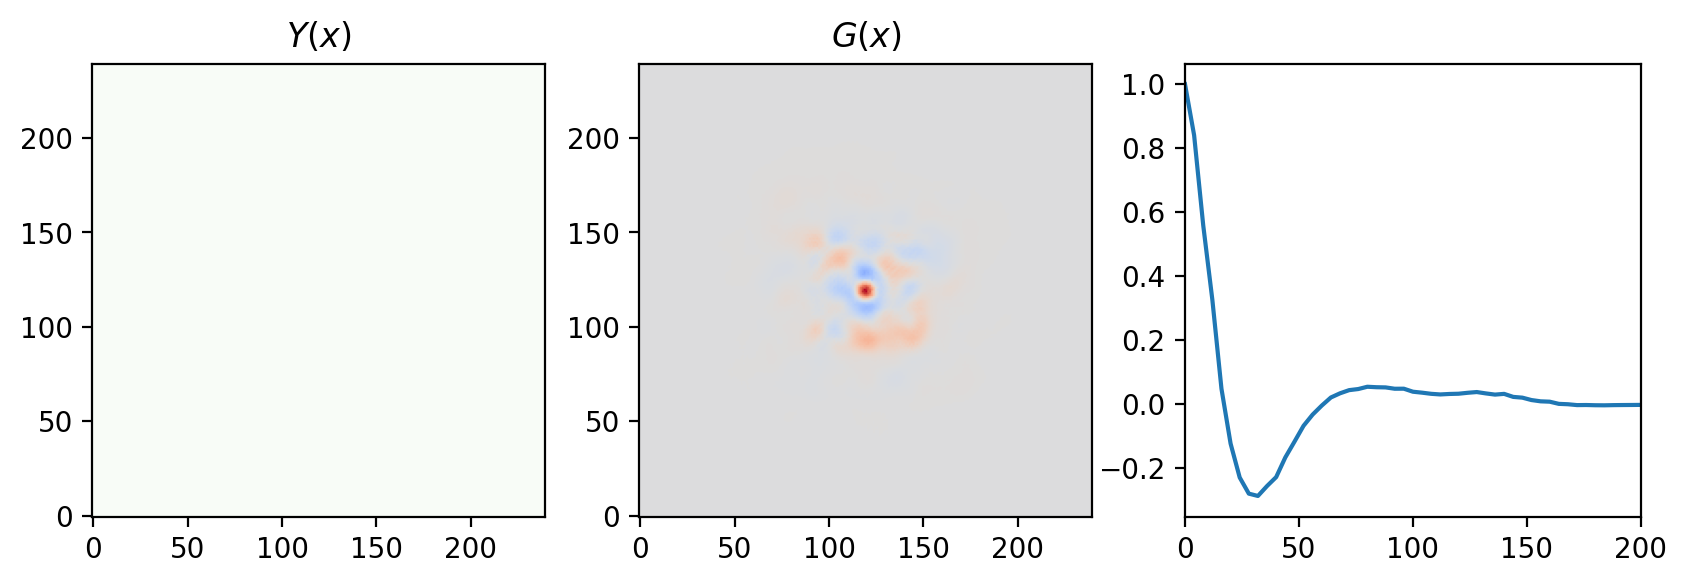

In [20]:
#g_crv = G_shift[G_shift.shape[0]//2-5:G_shift.shape[0]//2+5, :]#60:130]

#print(G_shift.shape[0])
#g_crv = np.mean(g_crv, axis=0)

rgrid = np.arange( G_shift.shape[0] ) - G_shift.shape[0] //2
rgrid = np.linalg.norm(np.stack(np.meshgrid(rgrid, rgrid, indexing='ij')), axis=0)
r = np.arange(1, G_shift.shape[0] // 2 +1)
kr = np.empty(len(r)-1)

for j in range(len(r)-1):
    kr[j] = np.average(G_shift[(rgrid>=r[j])*(rgrid< r[j+1])])


fig,ax=plt.subplots(1,3,figsize=(10,3),dpi=200)
sample=dataset[0]

y_im, y_mesh_vals, _ = model.forward(sample['zyx'], sample['Y_FctSpace'])
mask = sample['mask_bool'].detach().numpy().squeeze()

ax[0].imshow(np.zeros_like(mask), cmap='Greens', origin='lower', alpha=0.8)
#ax[0].tripcolor(*tricolor(ufl.sqrt(ufl.dot(Y_mesh,Y_mesh)), mesh), vmin=0,vmax=2e-3, cmap='Greens')

ax[1].imshow(G_shift/G_shift.max(), cmap='coolwarm', origin='lower', vmax=1, vmin=-1)

ax[2].plot(np.arange(len(kr))*4, kr/kr.max())

#ax[0].scatter(95, 170-5, color='k', marker=6)
#ax[0].scatter(95-10, 170, color='k', marker=9)
#ax[1].scatter(95, 170-5, color='k', marker=6)

ax[0].set_title("$Y(x)$")
ax[1].set_title("$G(x)$")
#ax[0].set_title("$Y(x)$")

ax[2].set_xlim(0, 200)

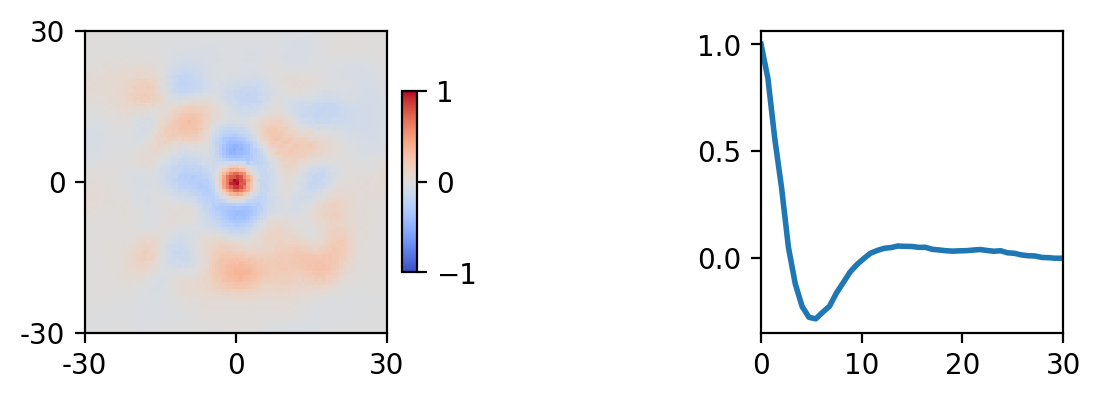

In [86]:
#g_crv = G_shift[G_shift.shape[0]//2-5:G_shift.shape[0]//2+5, :]#60:130]

#print(G_shift.shape[0])
#g_crv = np.mean(g_crv, axis=0)

rgrid = np.arange( G_shift.shape[0] ) - G_shift.shape[0] //2
rgrid = np.linalg.norm(np.stack(np.meshgrid(rgrid, rgrid, indexing='ij')), axis=0)
r = np.arange(1, G_shift.shape[0] // 2 +1)
kr = np.empty(len(r)-1)

for j in range(len(r)-1):
    kr[j] = np.average(G_shift[(rgrid>=r[j])*(rgrid< r[j+1])])


fig,ax=plt.subplots(1,2,figsize=(8,2),dpi=200)
ax = ax[::-1]
sample=dataset[0]

Gim = ax[1].imshow(G_shift/G_shift.max(), 
             cmap='coolwarm', origin='lower', vmax=1, vmin=-1,
            extent=4*0.17*np.asarray([-G_shift.shape[0]//2-0.5, G_shift.shape[0]//2+0.5,
                                 -G_shift.shape[0]//2-0.5, G_shift.shape[0]//2+0.5 ])) # x0, x1, y0, y1

ax[0].plot(np.arange(len(kr))*4*0.17, kr/kr.max(), lw=2)
ax[0].set_xlim(0, 30)

ax[0].set_aspect(1*np.diff(ax[0].get_xlim())/np.diff(ax[0].get_ylim()))
ax[0].set_yticks([0, 0.5, 1])

#ax[0].axis('off')
lim = 30
ax[1].set_xlim(-lim, lim)
ax[1].set_ylim(-lim, lim)

ax[1].set_yticks([-lim,0,lim])
ax[1].set_yticklabels([-lim,0,lim])
ax[1].set_xticks([-lim,0,lim])
ax[1].set_xticklabels([-lim,0,lim])

cax = ax[1].inset_axes([1.05, 0.2, 0.05, 0.6])
cb = fig.colorbar(Gim, cax=cax, ticks=[-1,0,1])


#ax[0].set_xlim(

5.44
2.72
8.16
6.800000000000001


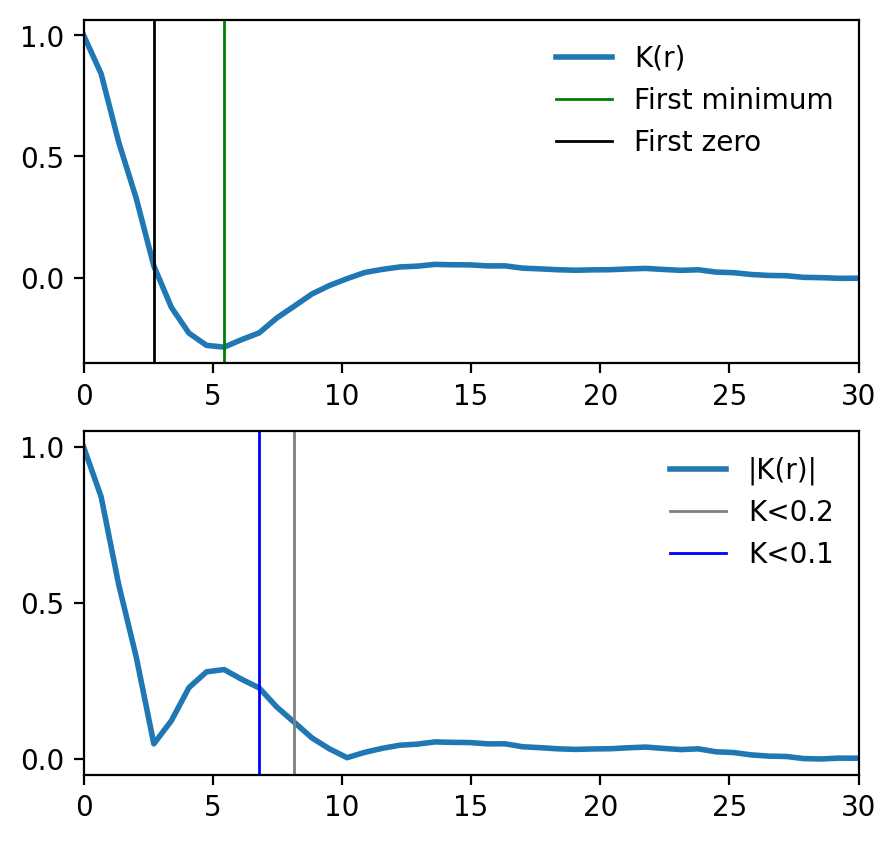

In [110]:
#g_crv = G_shift[G_shift.shape[0]//2-5:G_shift.shape[0]//2+5, :]#60:130]

#print(G_shift.shape[0])
#g_crv = np.mean(g_crv, axis=0)

rgrid = np.arange( G_shift.shape[0] ) - G_shift.shape[0] //2
rgrid = np.linalg.norm(np.stack(np.meshgrid(rgrid, rgrid, indexing='ij')), axis=0)
r = np.arange(1, G_shift.shape[0] // 2 +1)
kr = np.empty(len(r)-1)

for j in range(len(r)-1):
    kr[j] = np.average(G_shift[(rgrid>=r[j])*(rgrid< r[j+1])])


fig,ax=plt.subplots(2,1,figsize=(5,5),dpi=200)

ax[0].plot(np.arange(len(kr))*4*0.17, kr/kr.max(), lw=2, label='K(r)')
ax[1].plot(np.arange(len(kr))*4*0.17, np.abs(kr/kr.max()), lw=2, label='|K(r)|')
for a in ax: a.set_xlim(0, 30)

#ax.set_aspect(1*np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
for a in ax: a.set_yticks([0, 0.5, 1])

L1 = next(r for r, K in zip(np.arange(len(kr))[::-1]*4*0.17, np.abs(kr/kr.max())[::-1]) if K>0.1)
L2 = next(r for r, K in zip(np.arange(len(kr))[::-1]*4*0.17, np.abs(kr/kr.max())[::-1]) if K>0.2)
L4 = next(r for r, K in zip(np.arange(len(kr))*4*0.17, kr[1:]/kr.max()) if K<0)
L3 = np.argmin(kr)*4*0.17

ax[1].axvline(L1, color='gray', lw=1, label='K<0.2')
ax[1].axvline(L2, color='blue', lw=1, label='K<0.1')
ax[0].axvline(L3, color='green', lw=1, label='First minimum')
ax[0].axvline(L4, color='black', lw=1, label='First zero')

for a in ax:
    a.legend(frameon=False)
print(L3)
print(L4)
print(L1)
print(L2)

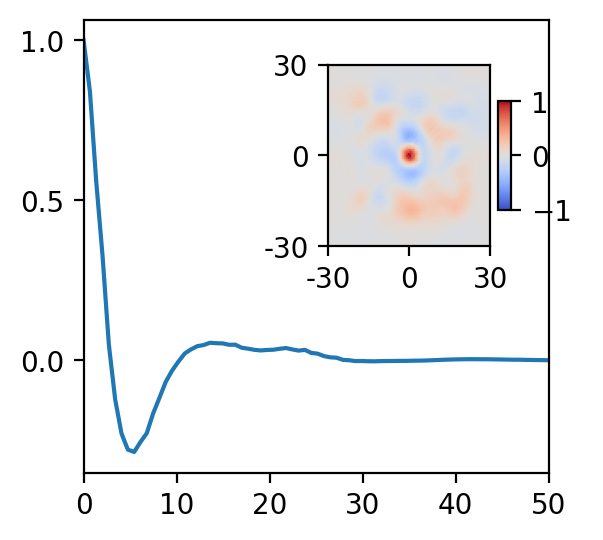

In [72]:
#g_crv = G_shift[G_shift.shape[0]//2-5:G_shift.shape[0]//2+5, :]#60:130]

#print(G_shift.shape[0])
#g_crv = np.mean(g_crv, axis=0)

rgrid = np.arange( G_shift.shape[0] ) - G_shift.shape[0] //2
rgrid = np.linalg.norm(np.stack(np.meshgrid(rgrid, rgrid, indexing='ij')), axis=0)
r = np.arange(1, G_shift.shape[0] // 2 +1)
kr = np.empty(len(r)-1)

for j in range(len(r)-1):
    kr[j] = np.average(G_shift[(rgrid>=r[j])*(rgrid< r[j+1])])


fig,ax=plt.subplots(1,1,figsize=(3,3),dpi=200)
sample=dataset[0]

inax = ax.inset_axes([0.5, 0.5, 0.4, 0.4])

Gim = inax.imshow(G_shift/G_shift.max(), 
             cmap='coolwarm', origin='lower', vmax=1, vmin=-1,
            extent=4*0.17*np.asarray([-G_shift.shape[0]//2-0.5, G_shift.shape[0]//2+0.5,
                                 -G_shift.shape[0]//2-0.5, G_shift.shape[0]//2+0.5 ])) # x0, x1, y0, y1

ax.plot(np.arange(len(kr))*4*0.17, kr/kr.max())
ax.set_xlim(0, 50)

#ax.set_aspect(np.diff(ax.get_xlim())/np.diff(ax.get_ylim()))
ax.set_yticks([0, 0.5, 1])

#ax[0].axis('off')
lim = 30
inax.set_xlim(-lim, lim)
inax.set_ylim(-lim, lim)

inax.set_yticks([-lim,0,lim])
inax.set_yticklabels([-lim,0,lim])
inax.set_xticks([-lim,0,lim])
inax.set_xticklabels([-lim,0,lim])

cax = inax.inset_axes([1.05, 0.2, 0.08, 0.6])
cb = fig.colorbar(Gim, cax=cax, ticks=[-1,0,1])

inax.set_aspect(1)

#ax[0].set_xlim(

In [189]:
x = np.linspace(0,10,1000)

f = np.exp(-((x-5)**2))

plt.plot(f)
#plt.plot(np.diff(f)/(x[1]-x[0]))
plt.plot(-np.diff(f, 2)/(x[1]-x[0])**2, label='$\frac{d^2}{dx^2} e^{-x^2}$')
plt.legend()

ValueError: 
$rac{d^2}{dx^2} e^{-x^2}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>